# Ground support script

Makes some useful figures to track convection etc

In [1]:
# Import a bunch of stuff

# Time and date, utilities
from datetime import datetime, timedelta, timezone
import intake
import os
import urllib.request

# Orcestra
from orcestra.flightplan import sal, bco, LatLon, IntoCircle, path_preview, plot_cwv, plot_path

# Satelite data
from goes2go.data import goes_nearesttime, goes_latest
from goes2go.tools import abi_crs
import goes


# The usual plotting business and arrary business
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import pandas as pd
import numpy as np
import scipy

# Image stuff
from PIL import Image
import requests
from io import BytesIO

import seaborn as sns
sns.set_context('notebook')

  

/Users/msin0007/opt/anaconda3/envs/ORCESTRA/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
/Users/msin0007/opt/anaconda3/envs/ORCESTRA/lib/python3.12/site-packages/goes2go/data.py:665: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1h")),
/Users/msin0007/opt/anaconda3/envs/ORCESTRA/lib/python3.12/site-packages/goes2go/NEW.py:188: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1h")),


## Set these parameters

In [2]:
# Set the time of this flight
take_off_time = datetime(2024, 8, 18, 12, 0, 0)

flight_id = 'HALO-' + take_off_time.strftime('%Y%m%d') +'a'

# Set the last forecast time for IFS
forecast_initialisation_time = datetime(2024, 8, 17, 12, 0, 0)

In [3]:
def make_output_dir(output_type):
   if not os.path.exists("./Figures/"+flight_id+"/"+output_type): 
       os.makedirs("./Figures/"+flight_id+"/"+output_type) 

make_output_dir('TCWV_forecast')
make_output_dir('VIS')
make_output_dir('IR')
make_output_dir('VIS_and_TPW')
make_output_dir('TPW')
make_output_dir('AOD')
make_output_dir('WV')



### First get the flight path

Can download this from here: https://orcestra-campaign.org/operation/halo.html

In [4]:
# Get the flight plan
# Download from: https://orcestra-campaign.org/operation/halo.html



radius = 130e3
atr_radius = 70e3

airport = sal
north_ec = LatLon(lat=13.1, lon=-28.5167)

circle_north = LatLon(lat=12, lon=-28.74)

circle_cloud = LatLon(lat=10.00, lon=-29.0667)

circle_center = LatLon(lat=8.05, lon=-29.4667)

circle_south = LatLon(lat=4.0, lon=-30.25)

south_ec = LatLon(lat=3.0, lon=-30.41667)

earthcare = LatLon(lat=8.05, lon=-29.4667)

atr = LatLon(lat=16.4212, lon=-21.8315)

leg_south = [
     airport,
     north_ec,
     south_ec
]

leg_circles = [
     IntoCircle(circle_south, radius, 360),
     IntoCircle(circle_center, radius, 360),
     earthcare,
     IntoCircle(circle_cloud, radius*1.5, 360),
     IntoCircle(circle_north, radius, 360),
]
    
leg_home = [
     north_ec,
     IntoCircle(atr, atr_radius, -360, enter = 180),
     airport
]

path = leg_south + leg_circles + leg_home 




### Now plot the forecast column water vapour

In [5]:
# Get the IFS forecast 
cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")



ds = cat.HIFS(datetime=forecast_initialisation_time.strftime('%Y-%m-%d %H:%M')).to_dask()


/var/folders/xk/pmwnlg9s1mb3q_2bdflswf1jp_tlkp/T/ipykernel_11587/706367869.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_time = datetime.utcnow()


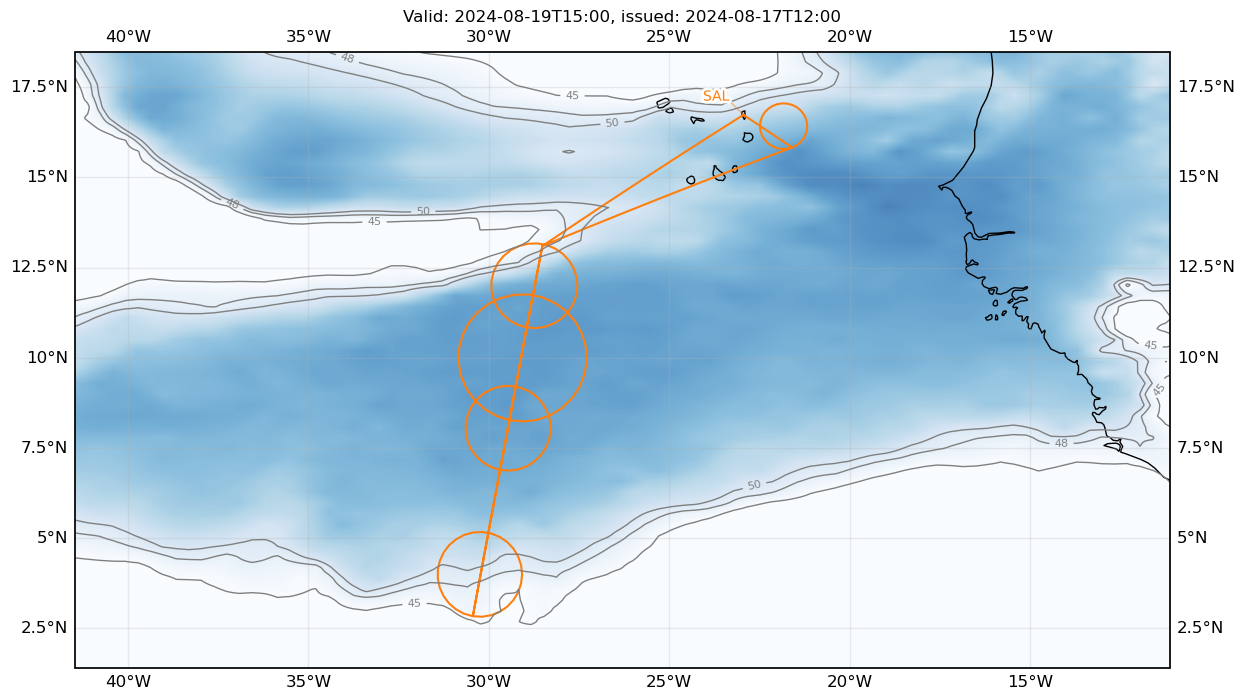

In [6]:
# PLot the column water vapour


# Select the one closest to current time
current_time = datetime.utcnow()
cwv_latest = ds["tcwv"].sel(time=current_time, method = "nearest")
time_of_cwv = ds["time"].sel(time=current_time, method = "nearest")

# Plot the flight path
ax = path_preview(path)

# PLot the column water vapour
plot_cwv(cwv_latest,levels=[45,48,50])

the_title = 'Valid: ' + str(time_of_cwv.values.astype('datetime64[m]')) + ', issued: ' + str(forecast_initialisation_time.strftime('%Y-%m-%dT%H:%M'))

plt.title(the_title)

plt.savefig('./Figures/'+flight_id+'/TCWV_forecast/TCWV_' + str(time_of_cwv.values.astype('datetime64[m]')) + '.png',dpi=100)


### Download total precipitable water estimate from satelite

## Now plot GOES snapshots

### Visible

/var/folders/xk/pmwnlg9s1mb3q_2bdflswf1jp_tlkp/T/ipykernel_11587/157134355.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_time = datetime.utcnow()


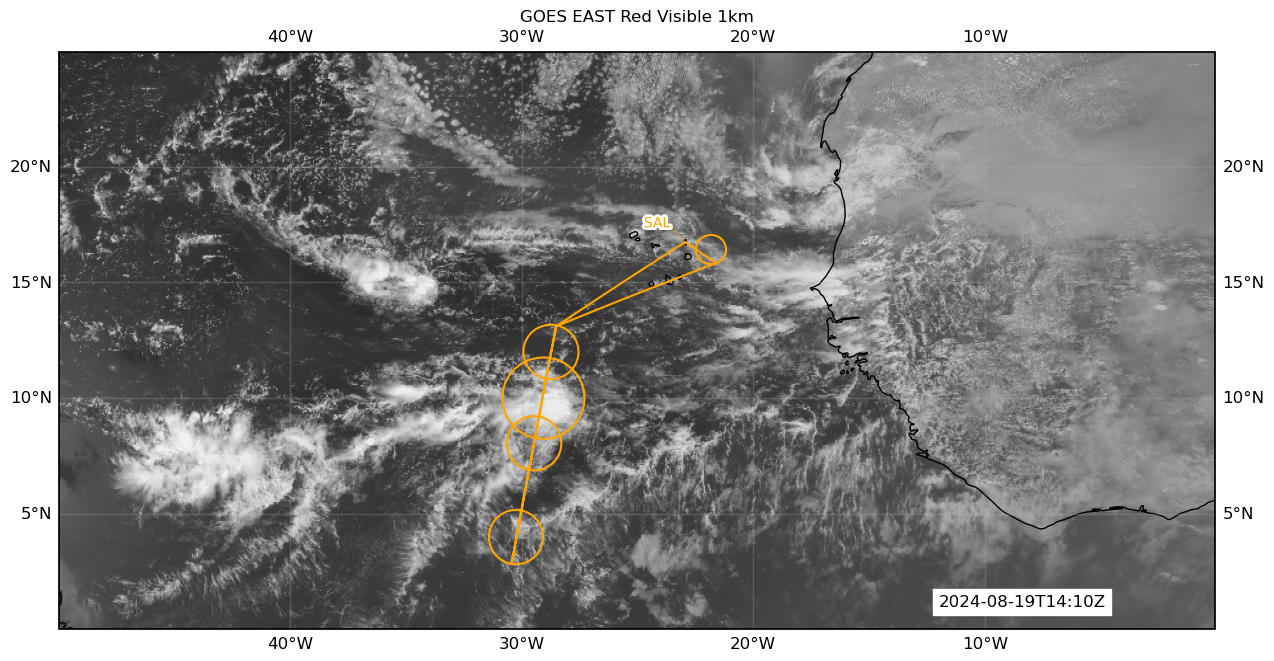

In [7]:
# Use NASA world view to get the most recent GOES visible image and plot it


# Get the current time
current_time = datetime.utcnow()
current_time_pd = pd.Timestamp(current_time)

# Use the goes.py package to plot the satellite image
fig,sat_time = goes.current_satellite_image_vis(current_time_pd)
ax = plt.gca()
sat_time = sat_time[:-4]+'Z'

# Plot the flight path
plot_path(path,ax=ax,color='orange')

ax.annotate(sat_time, (-12, 1), backgroundcolor="white")

plt.savefig('./Figures/'+flight_id+'/VIS/GOES_vis_' + sat_time + '.png')




### IR

/var/folders/xk/pmwnlg9s1mb3q_2bdflswf1jp_tlkp/T/ipykernel_11587/1483997186.py:4: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_time = datetime.utcnow()


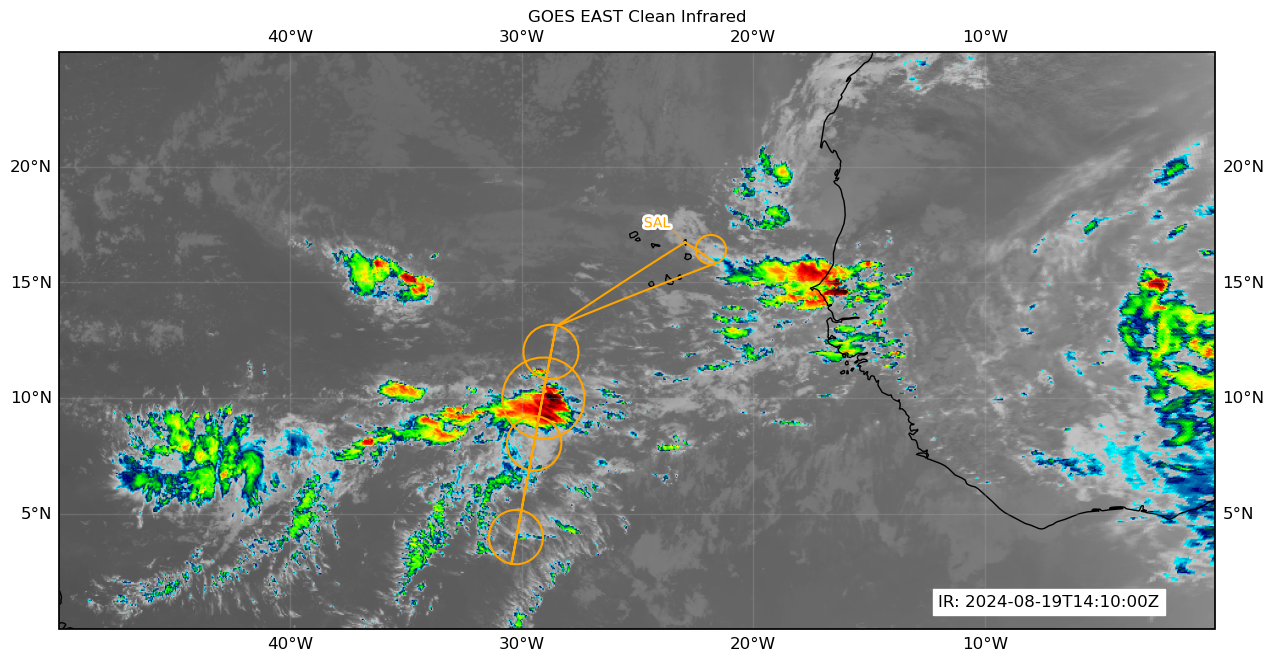

In [8]:
# Use NASA world view to get the most recent GOES visible image and plot it

# Get the current time
current_time = datetime.utcnow()
current_time_pd = pd.Timestamp(current_time)

# Use the goes.py package to plot the satellite image
fig,sat_time = goes.current_satellite_image_ir(current_time_pd)
ax = plt.gca()

# Plot the flight path
plot_path(path,ax=ax,color='orange')

ax.annotate('IR: ' + sat_time, (-12, 1), backgroundcolor="white")

plt.savefig('./Figures/'+flight_id+'/IR/GOES_IR_' + sat_time + '.png')


## Total column water vapour products

### Download the TCWV from the ABI

In [9]:
current_time = datetime.utcnow()

try:
   
   print('downloading TPW data')
   # Get the latest TPW image
   g_TPW = goes_latest(satellite='goes16',product='ABI-L2-TPW', domain='F')

except:
   # Otherwise get something a bit older
   print("could not find latest TPW, trying to get file from 2 hours ago")
   time_sat = current_time - timedelta(hours=2)
   g_TPW = goes_nearesttime(time_sat, satellite=16, product="ABI-L2-TPW", domain = "F")


/var/folders/xk/pmwnlg9s1mb3q_2bdflswf1jp_tlkp/T/ipykernel_11587/878423445.py:1: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_time = datetime.utcnow()


downloading TPW data
📦 Finished downloading [1] files to [/Users/msin0007/data/noaa-goes16/ABI-L2-TPWF].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

### Visible and TPW

/var/folders/xk/pmwnlg9s1mb3q_2bdflswf1jp_tlkp/T/ipykernel_11587/3434475014.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_time = datetime.utcnow()


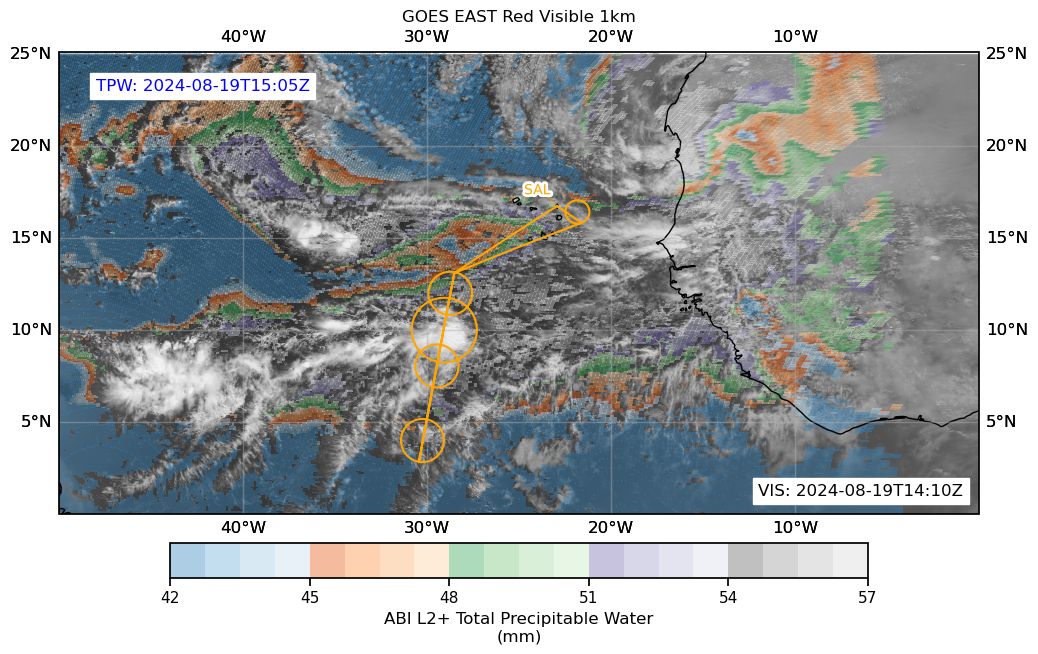

In [10]:
# Use NASA world view to get the most recent GOES visible image and plot it


# Get the current time
current_time = datetime.utcnow()
current_time_pd = pd.Timestamp(current_time)

# Use the goes.py package to plot the satellite image
fig,sat_time = goes.current_satellite_image_vis(current_time_pd)
ax = plt.gca()
sat_time = sat_time[:-4]+'Z'

# Plot the flight path
plot_path(path,ax=ax,color='orange')

ax.annotate('VIS: ' + sat_time, (-12, 1), backgroundcolor="white")


# No idea what this does
crs, x, y = abi_crs(g_TPW, 'TPW')

# Plot the Total column water vapor semi-transparently
c = ax.pcolormesh(x, y, g_TPW.TPW, transform=crs, cmap='tab20c', vmin=42,vmax=57,alpha=0.4)
cc = plt.colorbar(c, ax=ax, shrink=.6, pad=.05, orientation='horizontal', label=f"{g_TPW.TPW.long_name}\n({g_TPW.TPW.units})",ticks=[42,45,48,51,54,57])

# Some niceness for the plot
ax.set_extent([-50, 0, 0, 23])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

ax.annotate('TPW: '+str(g_TPW.t.values.astype('datetime64[m]'))+'Z', (-48, 23), backgroundcolor="white",color="blue")

plt.savefig('./Figures/'+flight_id+'/VIS_and_TPW/GOES_vis_and_TPW_' + sat_time + '.png',dpi=200)



### ABI TPW on its own

<Figure size 1000x500 with 0 Axes>

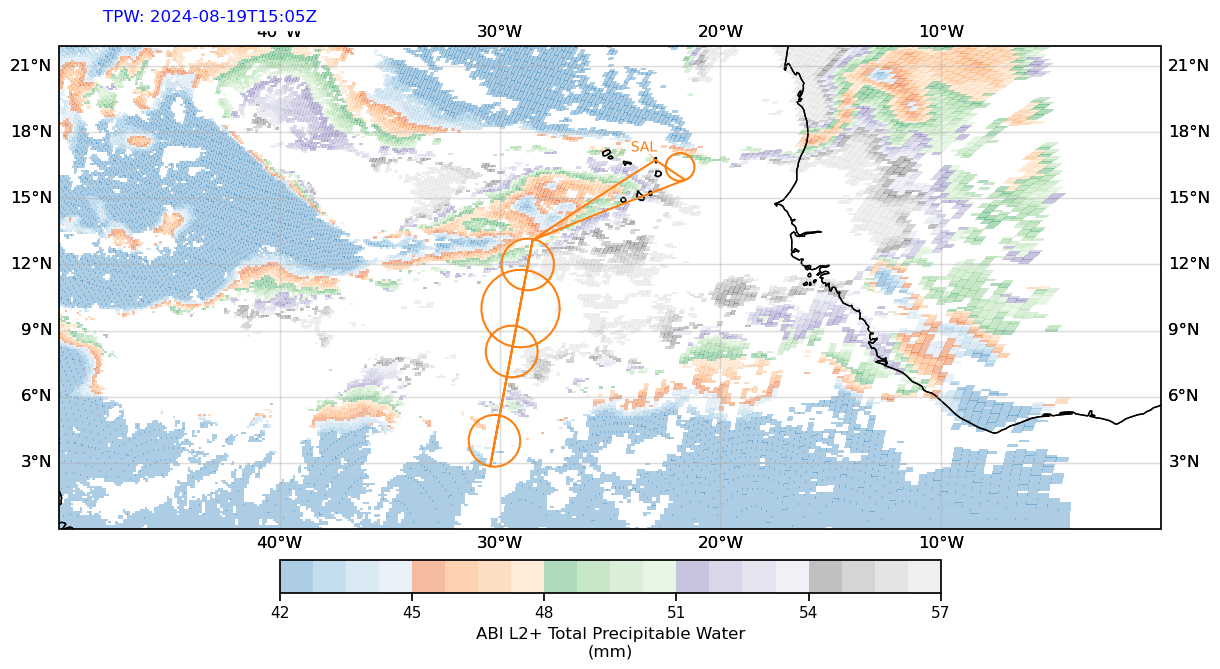

In [11]:
# Create the figure
projection = ccrs.PlateCarree()
plt.figure(figsize=(10, 5))

# Plot the flight path
ax = path_preview(path)
ax.set_global()
ax.coastlines()

# plot the water vapour field

# No idea what this does
crs, x, y = abi_crs(g_TPW, 'TPW')

# Plot the Total column water vapor semi-transparently
c = ax.pcolormesh(x, y, g_TPW.TPW, transform=crs, cmap='tab20c', vmin=42,vmax=57,alpha=0.4)
cc = plt.colorbar(c, ax=ax, shrink=.6, pad=.05, orientation='horizontal', label=f"{g_TPW.TPW.long_name}\n({g_TPW.TPW.units})",ticks=[42,45,48,51,54,57])

# Some niceness for the plot
ax.set_extent([-50, 0, 0, 20])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

ax.annotate('TPW: '+str(g_TPW.t.values.astype('datetime64[m]'))+'Z', (-48, 23), backgroundcolor="white",color="blue")


plt.savefig('./Figures/'+flight_id+'/TPW/GOES_TPW_' + str(g_TPW.t.values.astype('datetime64[m]')) + '.png',dpi=200)

### TCWV from daily AMRSU

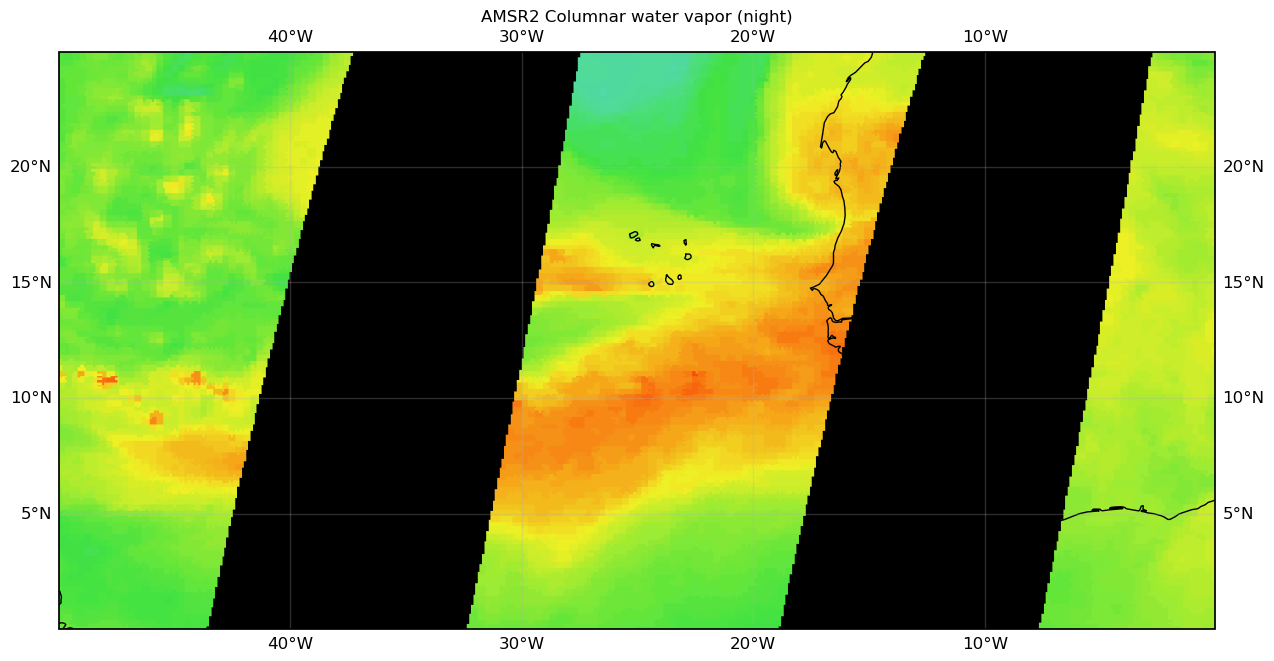

In [12]:
current_day = datetime.today()
current_day_pd = pd.Timestamp(current_day)


fig,sat_time,goes_image = goes.current_satellite_image_wv_night(current_day_pd)


/var/folders/xk/pmwnlg9s1mb3q_2bdflswf1jp_tlkp/T/ipykernel_11587/3437649949.py:7: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_time = datetime.utcnow()


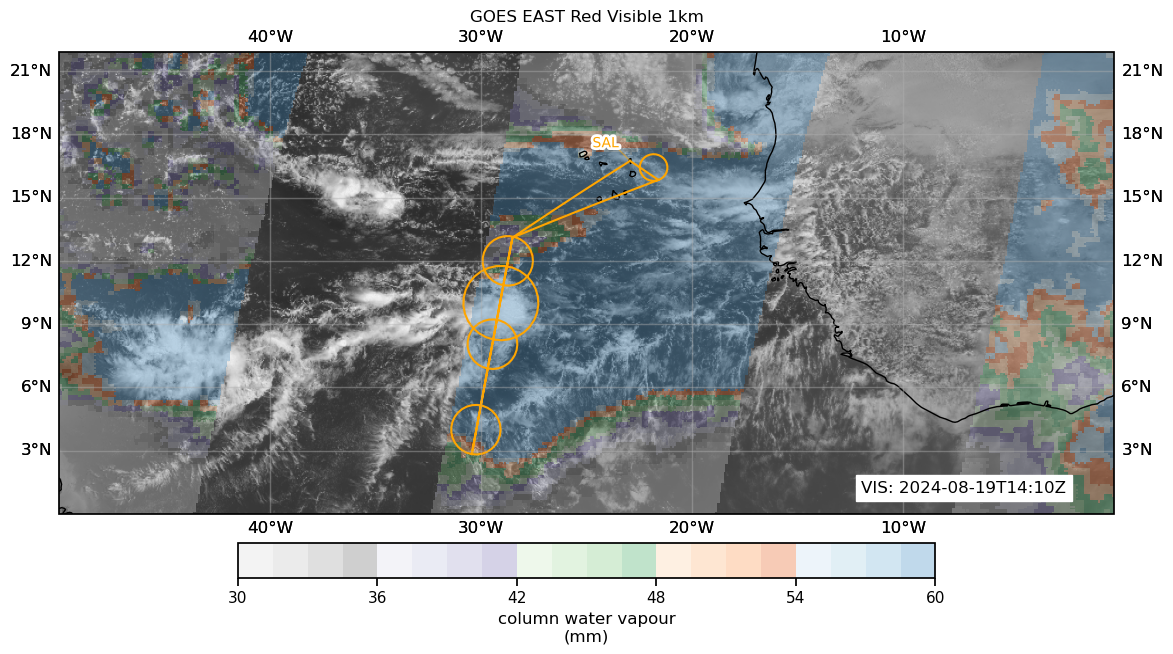

In [13]:
CWV = goes_image.values*(75/255)
CWV = CWV[0,:,:]
CWV = np.where(CWV==0,np.nan,CWV)


# Get the current time
current_time = datetime.utcnow()
current_time_pd = pd.Timestamp(current_time)

# Use the goes.py package to plot the satellite image
fig,sat_time = goes.current_satellite_image_vis(current_time_pd)
ax = plt.gca()
sat_time = sat_time[:-4]+'Z'

# Plot the flight path
plot_path(path,ax=ax,color='orange')

ax.annotate('VIS: ' + sat_time, (-12, 1), backgroundcolor="white")


# plot the water vapour field



# Plot the Total column water vapor semi-transparently
c = ax.pcolormesh(goes_image.x, goes_image.y, CWV, cmap='tab20c_r', vmin=30,vmax=60,alpha=0.3)
cc = plt.colorbar(c, ax=ax, shrink=.6, pad=.05, orientation='horizontal', label=f"column water vapour\n(mm)",ticks=[30,36,42,48,54,60])

# Some niceness for the plot
ax.set_extent([-50, 0, 0, 20])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

#ax.annotate('TPW: '+str(g_TPW.t.values.astype('datetime64[m]'))+'Z', (-48, 23), backgroundcolor="white",color="blue")

plt.savefig('./Figures/'+flight_id+'/VIS_and_TPW/GOES_VIS_AMSRU_TPW_' + sat_time + '.png',dpi=200)



### Column water vapour "MIMIC" from Microwave combined with Geostationary

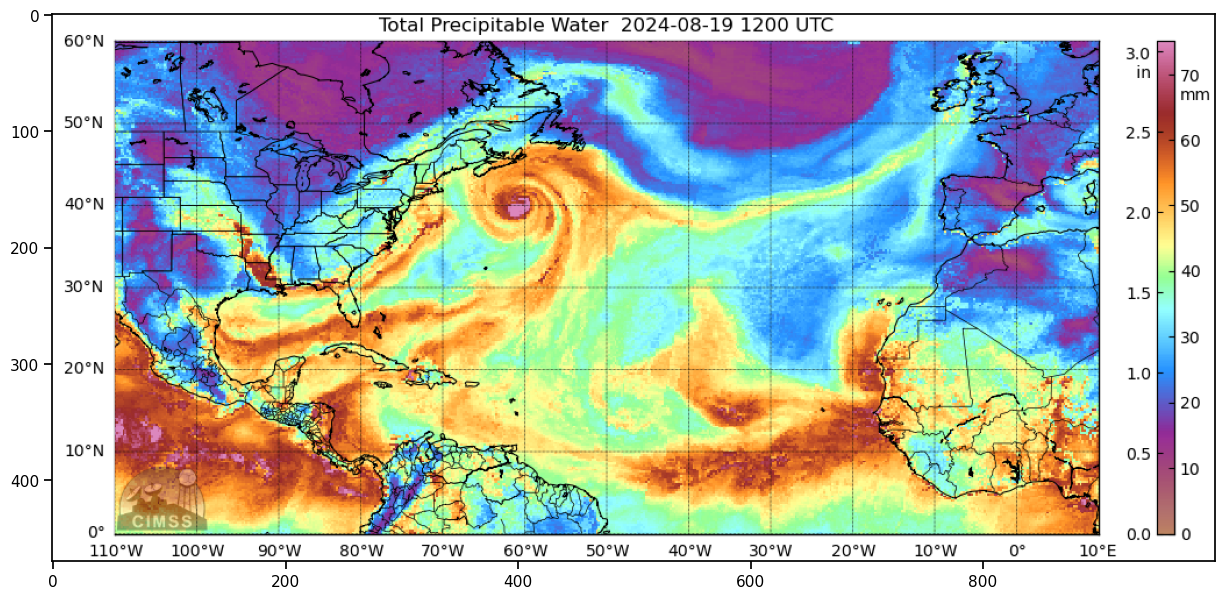

In [14]:
# Try to get the column water vapour image

url_prefix = 'https://tropic.ssec.wisc.edu/real-time/mtpw2/webImages/tpw_nrl_colors/natl/'
fname_url = url_prefix+"file_of_filenames_24.txt"


contents = urllib.request.urlopen(fname_url).read().splitlines()

# Going a few hours back on the recommendation of Florian
image_name = contents[-3].decode("utf-8")

sat_date = image_name[-23:-15]
sat_time = image_name[-14:-12]+':'+image_name[-10:-8]



image_name = url_prefix+image_name
TPW_image = np.array(Image.open(urllib.request.urlopen(image_name)))

# This is super dumb. Sorry Lukas.

col = np.sum(TPW_image[:,:,0:3],2)

# Find the indices of the non-zero elements
indices = np.nonzero(col[120,:]<255*3)

# The first and last indices will be the first and last True values
Xf = indices[0][0]
Xl = indices[0][-1]

# Find the indices of the non-zero elements
indices = np.nonzero(col[:,200]<255*3)

# The first and last indices will be the first and last True values
Yf = indices[0][0]
Yl = indices[0][-1]


TPW_image_cropped = TPW_image[Yf:Yl,Xf:Xl,:]

colbar = TPW_image_cropped[:,-10,:]
colbar = colbar[-2:2:-1,:]/255

col = np.sum(TPW_image_cropped[:,:,0:3],2)

# Find the indices of the non-zero elements
indices = np.nonzero(col[120,:]==255*3)

# The first and last indices will be the first and last True values
Xf = indices[0][0]


TPW_image_cropped = TPW_image_cropped[:,:Xf,:]




N = np.shape(TPW_image_cropped);

x = np.linspace(-110,10,N[1])
y = np.linspace(0,60,N[0])

TPW_matrix = np.flipud(TPW_image_cropped)

TPW_values = TPW_matrix[:,:,0]/255*75


plt.figure(figsize=(15,9))
plt.imshow(TPW_image)


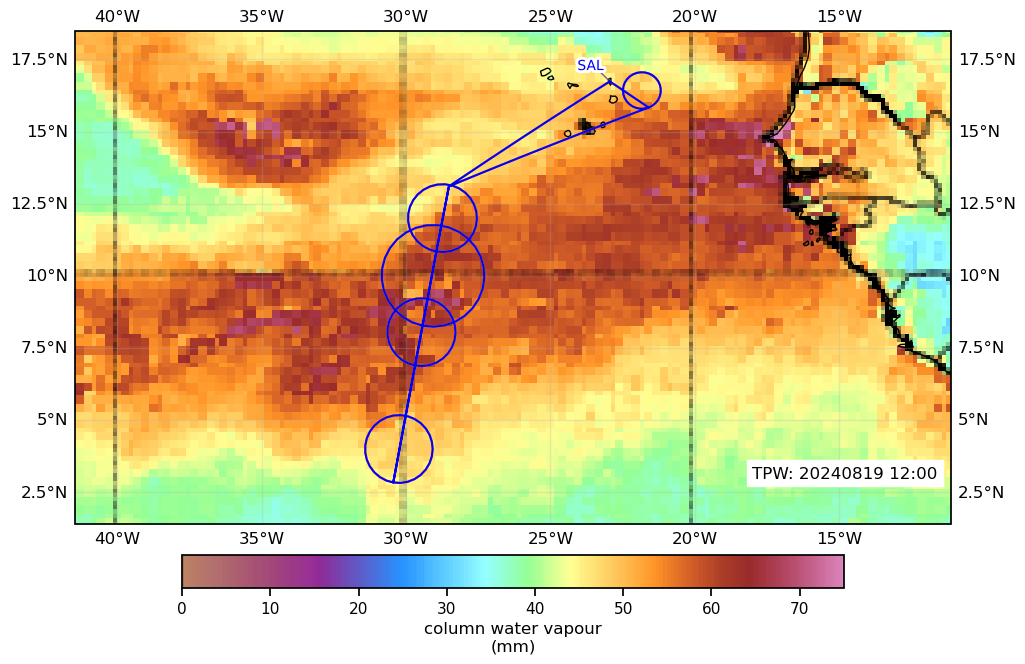

In [15]:

# For some reason I don't know how to create a geoaxes - so using path_preview to do this
ax = path_preview(path)
plot_path(path,ax=ax,color='blue')

newcmp = mpl.colors.ListedColormap(colbar)

c = ax.pcolormesh(x, y, TPW_matrix, cmap=newcmp, vmin=0,vmax=75,alpha=1)
cc = plt.colorbar(c, ax=ax, shrink=.6, pad=.05, orientation='horizontal', label=f"column water vapour\n(mm)",ticks=[0,10,20,30,40,50,60,70])

ax.annotate('TPW: ' + sat_date + ' ' + sat_time , (-18, 3), backgroundcolor="white")

plt.savefig('./Figures/'+flight_id+'/TPW/MIMIC_TPW2_' + sat_date + ' ' + sat_time + '.png',dpi=200)




In [59]:
# An attempt to do something fancy to recover the CWV from the image 
# currently DOES NOT WORK
# cwv_values = np.linspace(0,75,len(colbar)).tolist()
# reversemap={}
# for color,value in zip(colbar,cwv_values):
#     print(color)
#     print(value)
#     col = color.tolist()
#     print(col)
#     reversemap[col] = value

TPWm = TPW_matrix[:,:,0:3]/255
colm = colbar[:,0:3]

TPWm = np.tile(TPWm,[len(colm),1,1,1])
TPWm = np.transpose(TPWm,[0,3,1,2])

colm = np.tile(colm,[1,1,1,1])
colm = np.transpose(colm,[2,3,0,1])


print(np.shape(TPWm))
print(np.shape(colm))


dist = np.sum((TPWm-colm)**2,1)

I = dist.argmin(axis=0)



(422, 3, 426, 849)
(422, 3, 1, 1)


In [60]:
np.shape(dist)

(422, 426, 849)

In [89]:

cwv_values = np.linspace(75,0,len(colbar)).tolist()
N = np.shape(I)
TWP_values = np.zeros(np.shape(I))
for i in range(N[0]-1):
   for j in range(N[1]-1):
      
      try:
         TPW_values[i,j] = cwv_values[I[i,j]]
      except:
         print(i,j)
         kneroer


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

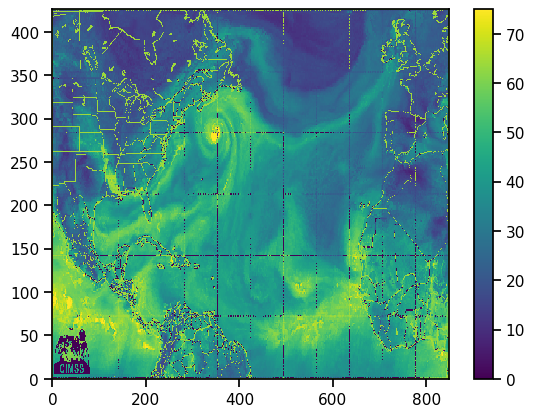

In [84]:
np.shape(y)
plt.pcolormesh(TPW_values)
plt.colorbar()


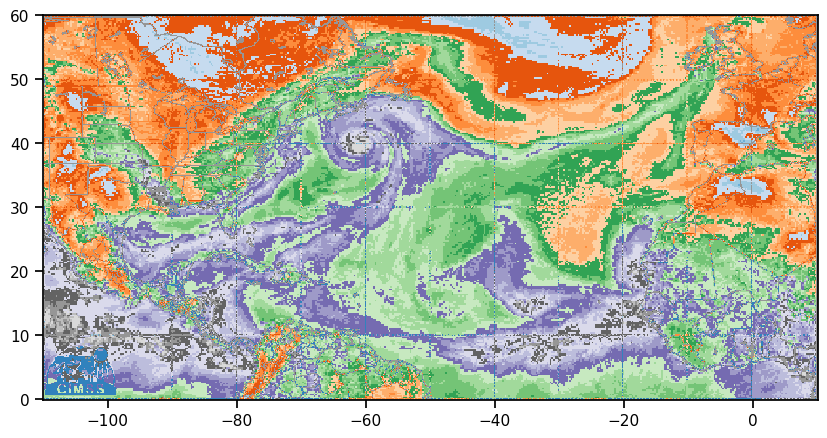

In [88]:
x = np.linspace(-110,10,N[1])
y = np.linspace(0,60,N[0])

# Create the figure
projection = ccrs.PlateCarree()
plt.figure(figsize=(10, 5))

# Plot the flight path
#ax = path_preview(path)
#ax.set_global()
#ax.coastlines()

# plot the water vapour field

# Plot the Total column water vapor semi-transparently
#c = ax.pcolormesh(x, y, TPW_values, transform=crs, cmap='tab20c', vmin=0,vmax=75,alpha=1)
c = plt.pcolormesh(x, y, TPW_values, cmap='tab20c', vmin=0,vmax=75,alpha=1)
cc = plt.colorbar(c, ax=ax, shrink=.6, pad=.05, orientation='horizontal', label=f"{'total column water'}\n({'mm'})",ticks=[42,45,48,51,54,57])

# Some niceness for the plot
#ax.set_extent([-50, 0, 0, 20])
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

#ax.annotate('TPW: '+str(g_TPW.t.values.astype('datetime64[m]'))+'Z', (-48, 23), backgroundcolor="white",color="blue")


#plt.savefig('./Figures/'+flight_id+'/TPW/MIMIC_TPW_' + str(g_TPW.t.values.astype('datetime64[m]')) + '.png',dpi=200)

In [80]:
np.shape(x)
N

(426, 849)

### Download AOD data

In [ ]:
try:
   print('downloading AOD data')
   # Get the latest AOD image
   g_AOD = goes_latest(satellite='goes16',product='ABI-L2-AOD', domain='F')

except:
   # Otherwise get something a bit older
   print("could not find latest AOD, trying to get file from 2 hours ago")
   time_sat = current_time - timedelta(hours=2)
   g_AOD = goes_nearesttime(time_sat, satellite=16, product="ABI-L2-AOD", domain = "F")



downloading AOD data
📦 Finished downloading [1] files to [/Users/msin0007/data/noaa-goes16/ABI-L2-AODF].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

### Aerosol optical depth

FileNotFoundError: [Errno 2] No such file or directory: '/Users/msin0007/Cirrus/Work/Research/ORCESTRA/flightplanning/notebooks/Figures/HALO-20240818a/AOD/GOES_AOD_2024-08-18T17:35.png'

<Figure size 1000x500 with 0 Axes>

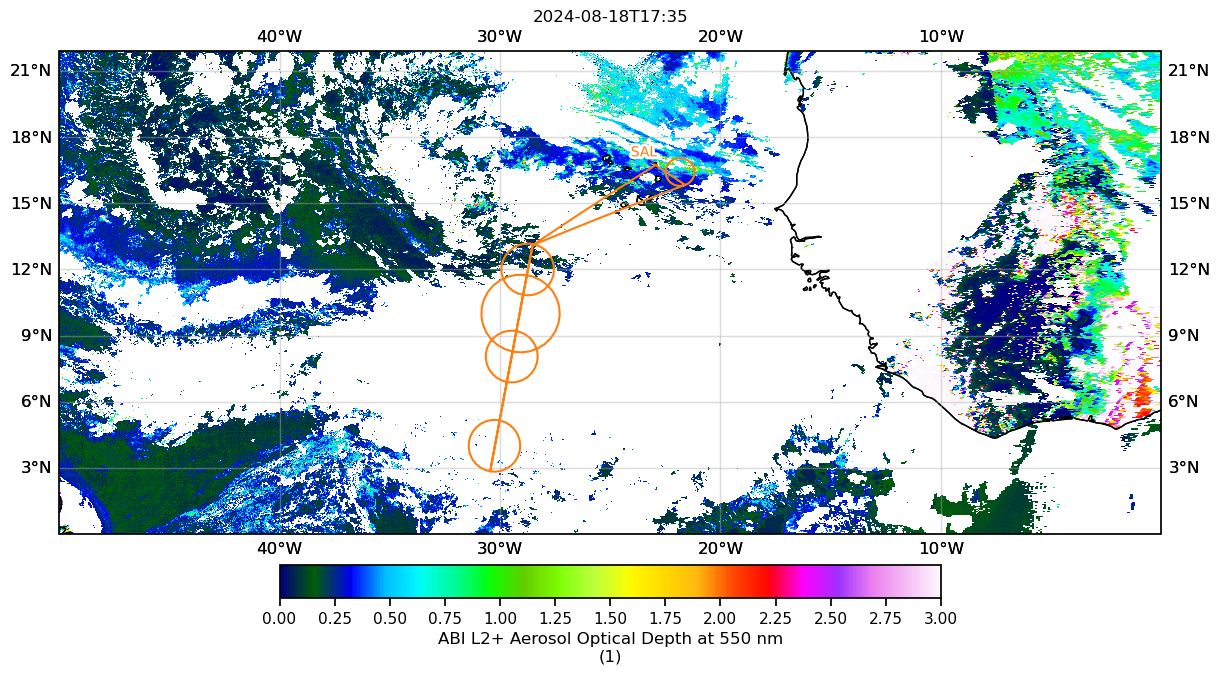

In [ ]:
# Create the figure
projection = ccrs.PlateCarree()
plt.figure(figsize=(10, 5))

# Plot the flight path
ax = path_preview(path)
ax.set_global()
ax.coastlines()


# No idea what this does
crs, x, y = abi_crs(g_AOD, 'AOD')

# Plot the Total column water vapor semi-transparently
c = ax.pcolormesh(x, y, g_AOD.AOD, transform=crs, cmap='gist_ncar', vmin=0,vmax=3,alpha=1)
cc = plt.colorbar(c, ax=ax, shrink=.6, pad=.05, orientation='horizontal', label=f"{g_AOD.AOD.long_name}\n({g_AOD.AOD.units})",ticks=[0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3])

# Some niceness for the plot
ax.set_extent([-50, 0, 0, 20])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

plt.title(g_AOD.t.values.astype('datetime64[m]'))

plt.savefig('./Figures/'+flight_id+'/AOD/GOES_AOD_' + str(g_AOD.t.values.astype('datetime64[m]')) + '.png',dpi=200)


### Download the full ABI data
This takes a long time, so commented out for now
But it can give you snapshots of the "water vapur" estimate from a mixture of channels

In [ ]:
# # Download the latest GOES information. This might take a long time
# try:
#    print('downloading ABI data')
#    # Get the latest visible image
#    g_visible = goes_latest(satellite='goes16',product='ABI',domain = 'F')

# except:
#    # Otherwise get something a bit older
#    print("could not find latest VIS, trying to get file from 2 hours ago")
#    time_sat = current_time - timedelta(hours=2)
#    g_visible = goes_nearesttime(time_sat, satellite=16, product="ABI", domain = "F")

# rgb_products = [i for i in dir(g_visible.rgb) if i[0].isupper()]
# rgb_products


In [ ]:

# # Plot the flight path
# ax = path_preview(path)
# ax.set_global()
# ax.coastlines()


# # No idea what this does
# goes_kwargs = g_visible.rgb.imshow_kwargs

# RGB = getattr(g_visible.rgb, 'WaterVapor')()

# # Plot the GOES visible satelite image
# ax.imshow(RGB, transform = g_visible.rgb.crs, regrid_shape=3500, interpolation='nearest') 

# ax.set_extent([-50, 0, 0, 20])
# ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)


# ax.set_title(f"{g_visible.orbital_slot} {'WaterVapor'}", loc='left', fontweight='bold')
# ax.set_title(f"{g_visible.t.dt.strftime('%H:%M UTC %d-%b-%Y').item()}", loc="right")



# plt.savefig('../Figures/'+flight_id+'/WV/GOES_WV_' + str(g_visible.t.values.astype('datetime64[m]')) + '.png',dpi=200)

